<a href="https://colab.research.google.com/github/minh071289/MachineLearning/blob/main/uet_ml_cifar100_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
Your task is to create a neural network to classify images in the cifar100 dataset.
- You have to write the code from scratch, train the model and test the accuracy on the test set.
- You are not allowed to use pretrained models to do this task.
- You have to submit the .ipynb files with the execution result.

# Grading criteria
- You are graded on the test set accuracy:
  - Test accuracy = 0.50, Grade = 6
  - Test accuracy = 0.55, Grade = 7
  - Test accuracy = 0.60, Grade = 8
  - Test accuracy = 0.65, Grade = 9
  - Test accuracy = 0.70, Grade = 10
- Plagiarism will automatically results in 0 mark.


In [1]:
# DO NOT MODIFY THIS CODE
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from tqdm.auto import tqdm, trange


In [2]:
# DO NOT MODIFY THIS CODE
cifar100_train = datasets.CIFAR100('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())

cifar100_test = datasets.CIFAR100('./data',
                              train=False,
                              download=True,
                              transform=transforms.ToTensor())

100%|██████████| 169M/169M [00:03<00:00, 44.2MB/s]


In [3]:
print(len(cifar100_train))
print(len(cifar100_test))

50000
10000


In [4]:
# DO NOT MODIFY THIS CODE
def evaluate(net: nn.Module,
             data) -> float:
  """
  Evaluates the neural network on the given data.
  @param net: the neural network to evaluate
  @param data: the data to evaluate on
  @return: the accuracy of the neural network on the given data
  """
  data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=100,
                                            shuffle=False)

  correct = 0
  total = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  net.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      pred_target = net(inputs).argmax(dim=1)
      correct += (pred_target == targets).sum().item()
      total += targets.size(0)

  return correct / total

In [7]:
def train(train_data,
          net,
          **kwargs) -> Tuple[nn.Module, list[float], list[float]]:
  """
  Trains the neural network on the given data.
  @param train_data: the data to train on
  @param net: the neural network to train
  @param kwargs: the keyword arguments such as learning rate, batch size, etc.
  @return: the trained neural network, train losses, and train accuracies
  """
  # NOTE: YOU ARE NOT ALLOWED TO PASS test_data AS A PARAMERTER TO THIS METHOD
  train_losses = []
  train_accuracies = []
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  net.train()

  # YOUR CODE HERE
  # Hints: you are free to normalize the training data, invent new architecture,
  # apply early stopping, regularization, or any other kinds of tricks here.

  # Example code
  train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=kwargs.get('batch_size', 64),
        shuffle=True
    )

  optimizer = opt.Adam(
      net.parameters(),
      lr=kwargs.get('lr', 1e-3),
      weight_decay=kwargs.get('weight_decay', 1e-5)  # L2 regularization
  )

  scheduler = torch.optim.lr_scheduler.StepLR(
      optimizer,
      step_size=kwargs.get('lr_step', 10),
      gamma=kwargs.get('lr_gamma', 0.5)
  )

  criterion = nn.CrossEntropyLoss()
  pbar = trange(kwargs.get('epochs', 20))

  for epoch in pbar:
      net.train()
      total_loss = 0

      for inputs, targets in tqdm(train_loader, leave=False):
          inputs, targets = inputs.to(device), targets.to(device)

          # Normalize inputs if needed
          if inputs.dim() > 2:
              inputs = (inputs - inputs.mean(dim=(1, 2, 3), keepdim=True)) / (
                  inputs.std(dim=(1, 2, 3), keepdim=True) + 1e-7)

          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, targets)
          loss.backward()

          # Clip gradients
          torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

          optimizer.step()
          total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      train_losses.append(avg_loss)

      # Evaluate accuracy on full train set
      accuracy = evaluate(net, train_data)
      train_accuracies.append(accuracy)

      pbar.set_description(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {accuracy:.4f}")
      scheduler.step()

  return net, train_losses, train_accuracies

In [ ]:
# Example code
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 100),
)
lr = 0.001
batch_size = 100
epochs = 100
net, train_losses, train_accuracies = train(train_data=cifar100_train,
                                            net=net,
                                            lr=lr,
                                            optimizer='adam',
                                            batch_size=batch_size,
                                            epochs=epochs)

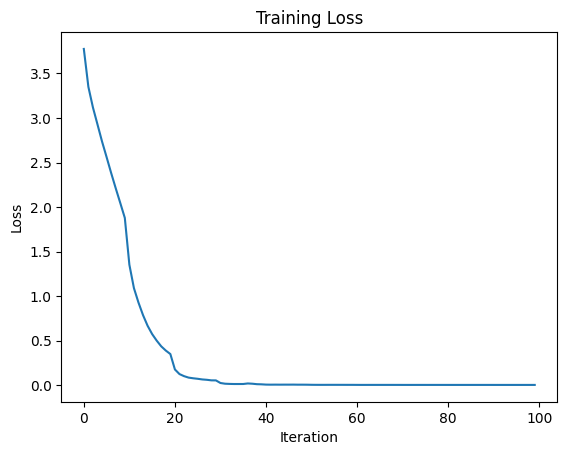

In [9]:
# DO NOT MODIFY THIS CODE
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

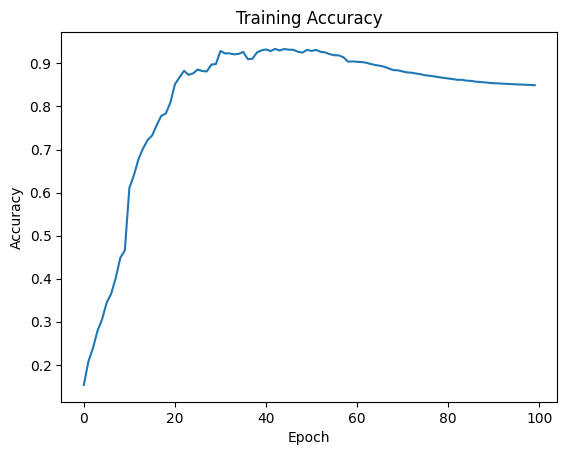

In [10]:
# DO NOT MODIFY THIS CODE
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [14]:
# DO NOT MODIFY THIS CODE
test_accuracy = evaluate(net, cifar100_test)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.2289
